<a href="https://colab.research.google.com/github/Alex-Chen1121/Deep-Leaning/blob/main/8_14_AutoEncoder%E5%9C%96%E7%89%87%E7%94%9F%E6%88%90_ipyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from tqdm.auto import tqdm

In [ ]:
BS = 128
EPOCHS = 10
LOG_INTERVAL = 100 # how many batches to wait before logging training status
device = "cuda" if torch.cuda.is_available() else "cpu"
use_mps = False
kwargs = {'num_workers': 1, 'pin_memory': True}

os.makedirs("results", exist_ok=True) # image dir

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()), # 0~1
    batch_size=BS, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.ToTensor()),
    batch_size=BS, shuffle=False, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 384096073.13it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37748736.00it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 174151173.36it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 3585644.41it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



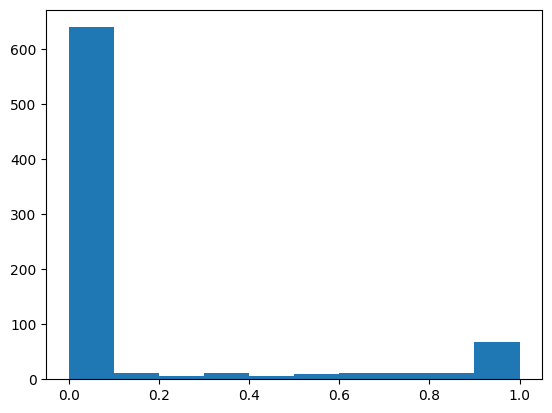

In [ ]:
# 資料數值分布在0~1之間 因此也都把圖片轉到0~1(to.tensor)
import matplotlib.pyplot as plt
img, label = train_loader.dataset[0]
plt.hist(img.view(-1))
plt.show()

In [ ]:
# 28*28*1 = 784
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.Linear(64, 128),
            nn.Linear(128, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x.view(-1, 784)) # 得到z向量 .view重新改造tensor的形狀
        output = self.decoder(z)
        return output

In [ ]:
model = AE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, leave=False)):
        data = data.to(device)
        optimizer.zero_grad()
        img_recon = model(data) # reconstruction
        loss = loss_func(img_recon, data.view(-1, 784)) # 正確答案就是原始影像
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            img_recon = model(data)
            test_loss += loss_func(img_recon, data.view(-1, 784)).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      img_recon.view(BS, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/AE_reconstruct_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
# training
for epoch in tqdm(range(1, EPOCHS + 1)):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 32).to(device) # 隨機丟向量進decoder 生成圖片 再用生成的圖片去跟原始資料做loss的計算
        sample = model.decoder(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/AE_sample_' + str(epoch) + '.png')

In [ ]:
torch.save(model.state_dict(), "ae.pt")

#### Reconstruct

In [ ]:
import matplotlib.pyplot as plt

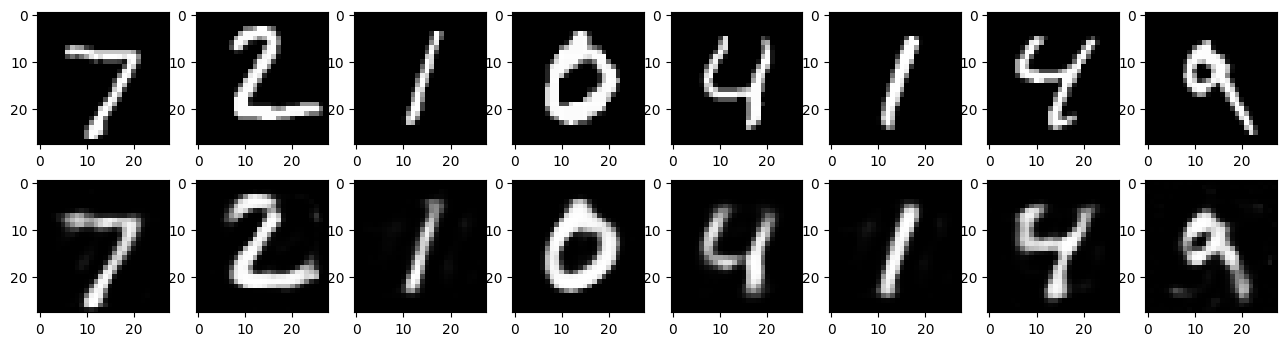

In [ ]:
for i, (data, _) in enumerate(test_loader):
    data = data.to(device)
    img_recon = model(data).view(BS, 1, 28, 28)
    n = min(data.size(0), 8)
    comparison = torch.cat([data[:n],
                          img_recon[:n]]).squeeze(1).detach().cpu()
    # show image
    plt.figure(figsize=(16, 4))
    for i in range(len(comparison)):
        plt.subplot(2, 8, i+1)
        plt.imshow(comparison[i], cmap="gray")
    plt.show()
    break

#### Generative

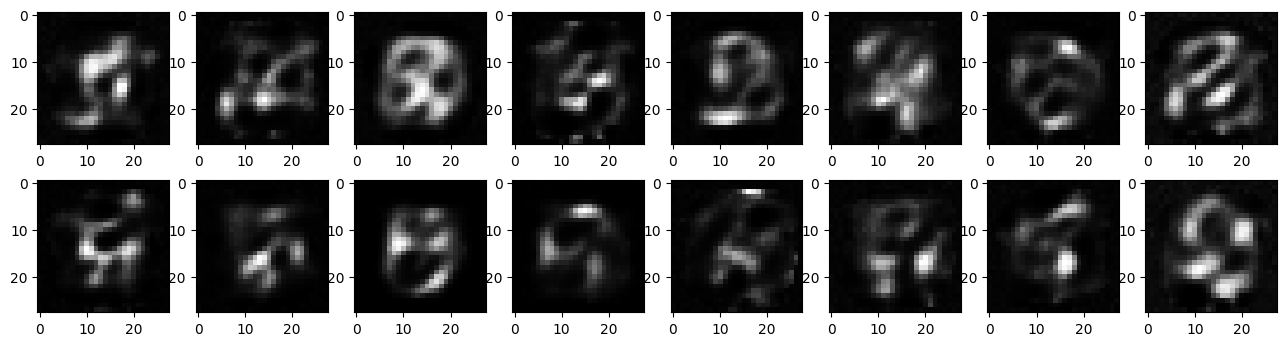

In [ ]:
with torch.no_grad():
    sample = torch.randn(16, 32).to(device)
    sample = model.decoder(sample).reshape(16, 28, 28).cpu()

# show image
plt.figure(figsize=(16, 4))
for i in range(len(sample)):
    plt.subplot(2, 8, i+1)
    plt.imshow(sample[i], cmap="gray")
plt.show()